# Libraries

In [1]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import networkx as nx

from pgmpy.models import BayesianNetwork
from pgmpy.estimators import *
from pgmpy.inference import VariableElimination
from pgmpy.metrics import *
from pgmpy.metrics.bn_inference import *

from sklearn.model_selection import train_test_split
from sklearn.metrics import *

import warnings
warnings.filterwarnings("ignore")

/home/matteo/Documenti/VSCODE/BayesianClassifier/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv(f'data{os.sep}heart.csv')

In [3]:
df = df[~(df['Cholesterol'] == 0) & ~(df['RestingBP'] == 0)]

In [4]:
df['ExerciseAngina'] = df['ExerciseAngina'].apply(lambda x: False if x == 'N' else True)
df['HeartDisease'] = df['HeartDisease'].apply(lambda x: False if x == 0 else True)
df['FastingBS'] = df['FastingBS'].apply(lambda x: False if x == 0 else True)

In [5]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,False,Normal,172,False,0.0,Up,False
1,49,F,NAP,160,180,False,Normal,156,False,1.0,Flat,True
2,37,M,ATA,130,283,False,ST,98,False,0.0,Up,False
3,48,F,ASY,138,214,False,Normal,108,True,1.5,Flat,True
4,54,M,NAP,150,195,False,Normal,122,False,0.0,Up,False


In [6]:
df.describe()

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak
count,746.000000,746.000000,746.000000,746.000000,746.000000
mean,52.882038,133.022788,244.635389,140.226542,0.901609
std,9.505888,17.282750,59.153524,24.524107,1.072861
min,28.000000,92.000000,85.000000,69.000000,-0.100000
25%,46.000000,120.000000,207.250000,122.000000,0.000000
50%,54.000000,130.000000,237.000000,140.000000,0.500000
75%,59.000000,140.000000,275.000000,160.000000,1.500000
max,77.000000,200.000000,603.000000,202.000000,6.200000


# Preprocessing

In [7]:
df['Oldpeak'].describe()

count    746.000000
mean       0.901609
std        1.072861
min       -0.100000
25%        0.000000
50%        0.500000
75%        1.500000
max        6.200000
Name: Oldpeak, dtype: float64

In [8]:
df[['Oldpeak', 'ST_Slope']].groupby('ST_Slope').describe()

Oldpeak                                             
           count      mean       std  min  25%  50%  75%  max
ST_Slope                                                     
Down        43.0  2.593023  1.333880  0.0  1.5  2.5  3.5  6.2
Flat       354.0  1.319774  0.979885  0.0  0.5  1.2  2.0  5.0
Up         349.0  0.269054  0.585470 -0.1  0.0  0.0  0.2  4.0

In [9]:
pd.qcut(x=df["Oldpeak"], q=3)

0      (-0.101, 0.0]
1         (0.0, 1.2]
2      (-0.101, 0.0]
3         (1.2, 6.2]
4      (-0.101, 0.0]
           ...      
913       (0.0, 1.2]
914       (1.2, 6.2]
915       (0.0, 1.2]
916    (-0.101, 0.0]
917    (-0.101, 0.0]
Name: Oldpeak, Length: 746, dtype: category
Categories (3, interval[float64, right]): [(-0.101, 0.0] < (0.0, 1.2] < (1.2, 6.2]]

In [10]:
df["Age"] = pd.qcut(x=df["Age"], q=2, labels=["young", "old"])
df["RestingBP"] = pd.cut(x=df["RestingBP"], bins=[90, 120, 140, 1000], labels=["normal", "high", "very high"])
df["Cholesterol"] = pd.cut(x=df["Cholesterol"], bins=[0, 200, 240, 1000], labels=["optimal", "borderline", "high"])
df["MaxHR"] = pd.cut(x=df["MaxHR"], bins=3)
df["Oldpeak"] = pd.cut(x=df["Oldpeak"], bins=3, labels=["low", "medium", "high"])

In [11]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,young,M,ATA,high,high,False,Normal,"(157.667, 202.0]",False,low,Up,False
1,young,F,NAP,very high,optimal,False,Normal,"(113.333, 157.667]",False,low,Flat,True
2,young,M,ATA,high,high,False,ST,"(68.867, 113.333]",False,low,Up,False
3,young,F,ASY,high,borderline,False,Normal,"(68.867, 113.333]",True,low,Flat,True
4,young,M,NAP,very high,optimal,False,Normal,"(113.333, 157.667]",False,low,Up,False


<Axes: xlabel='Age,Cholesterol'>

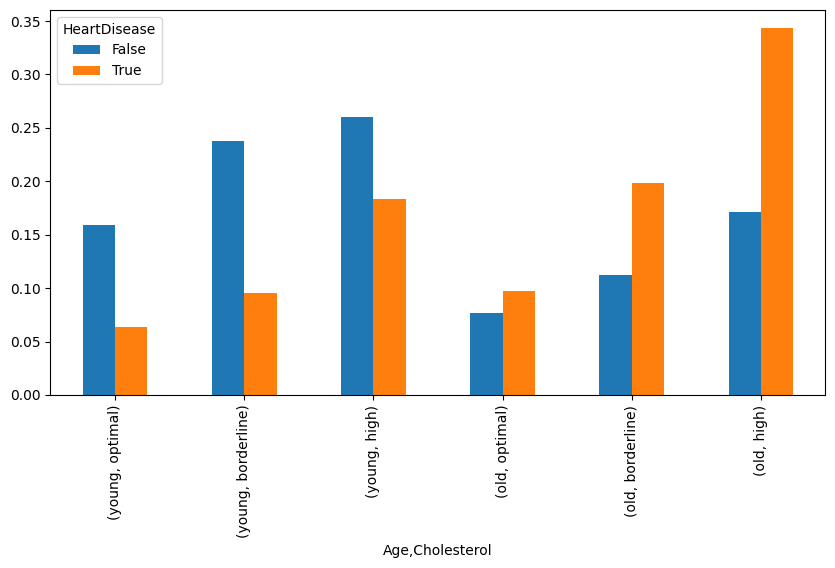

In [12]:
df[['Cholesterol', 'HeartDisease', 'Age']].groupby(
    'Age').value_counts(normalize=True).unstack().plot(kind='bar', stacked=False, figsize=(10, 5))

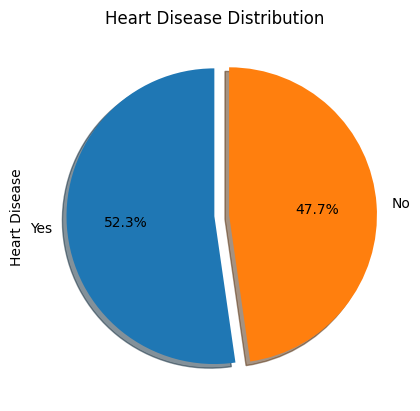

In [13]:
df["HeartDisease"].value_counts().plot(kind="pie", autopct='%1.1f%%', startangle=90, explode=[0, 0.1], shadow=True, labels=["Yes", "No"], label="Heart Disease", title="Heart Disease Distribution")
plt.show()

In [14]:
target_variable = "HeartDisease"

In [15]:
X, y = df.drop(columns=target_variable), df[target_variable]

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

# Bayesian Network from Hill Climbing unconstrained

In [44]:
estimated_model = HillClimbSearch(df, use_cache=False).estimate(
    scoring_method='BDeuScore')

  0%|          | 17/1000000 [00:11<191:02:05,  1.45it/s]


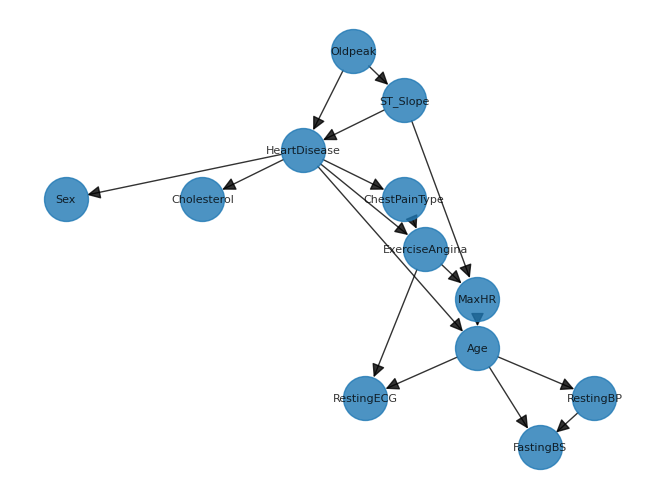

In [45]:
pos = nx.nx_pydot.graphviz_layout(estimated_model, prog='dot')
nx.draw(estimated_model, pos, with_labels=True, node_size=1000, font_size=8, arrowsize=20, alpha=0.8)

Ok, good but we want to express some edges and remove other with no causal meaning. We proceed to remove:
- HeartDisease -> Cholesterol
- Oldpeak -> HeartDisease
- ST_Slope -> HeartDisease
- ST_Slope -> MaxHR
- Nothing affects Age
- Nothing affects Sex

# Constrained

In [49]:
black_list = [(target_variable, 'Cholesterol'),
              ('Oldpeak', target_variable),
              ('ST_Slope', target_variable),
              ('ST_Slope', 'MaxHR')] + [(x, 'Sex')for x in df.columns] + [(x, 'Age') for x in df.columns]

In [90]:
estimated_model = HillClimbSearch(df, use_cache=False).estimate(
    scoring_method='BDeuScore', black_list=black_list)

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 18/1000000 [00:10<167:11:44,  1.66it/s]


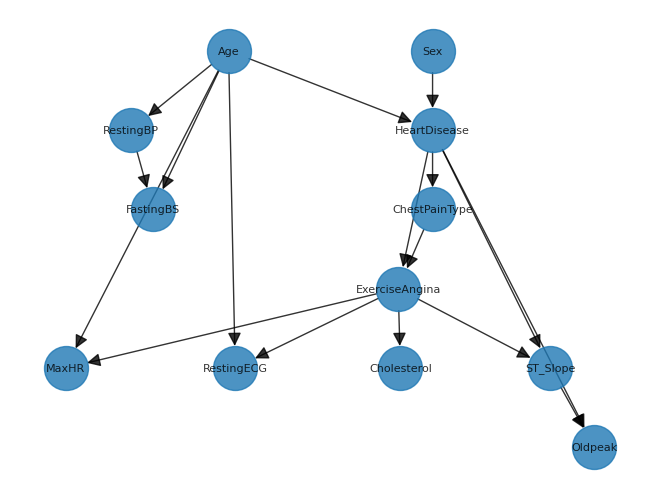

In [91]:
pos = nx.nx_pydot.graphviz_layout(estimated_model, prog='dot')
nx.draw(estimated_model, pos, with_labels=True,
        node_size=1000, font_size=8, arrowsize=20, alpha=0.8)

In [92]:
estimated_model.remove_edge('ExerciseAngina', 'Cholesterol')
estimated_model.add_edge('Sex', 'Cholesterol')
estimated_model.add_edge('Cholesterol', target_variable)
# estimated_model.add_edge('Age', 'Cholesterol')

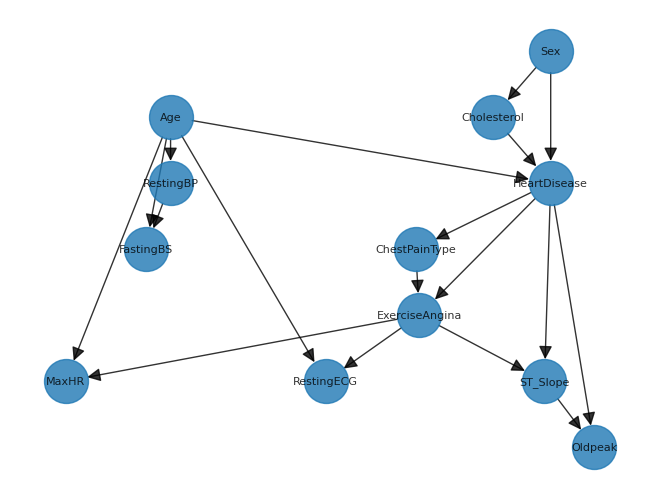

In [93]:
pos = nx.nx_pydot.graphviz_layout(estimated_model, prog='dot')
nx.draw(estimated_model, pos, with_labels=True,
        node_size=1000, font_size=8, arrowsize=20, alpha=0.8)

In [86]:
model = BayesianNetwork(estimated_model.edges())

In [94]:
model.get_cardinality()

defaultdict(int,
            {'Age': 2,
             'RestingECG': 3,
             'RestingBP': 3,
             'HeartDisease': 2,
             'FastingBS': 2,
             'MaxHR': 3,
             'Sex': 2,
             'Cholesterol': 3,
             'ChestPainType': 4,
             'ExerciseAngina': 2,
             'ST_Slope': 3,
             'Oldpeak': 3})

In [87]:
model.fit(train, estimator=BayesianEstimator, prior_type="BDeu")
model.get_cpds()
assert model.check_model()

In [88]:
y_pred = model.predict(X_test)
y_pred.head()

100%|██████████| 141/141 [00:00<00:00, 1487.21it/s]


,HeartDisease
0,False
1,False
2,False
3,False
4,True


In [89]:
fbeta_score(y_test, y_pred[target_variable], beta=2)

0.8656330749354005

# Naive Bayes

In [ ]:
nb_model = BayesianNetwork([(target_variable, y) for y in X.columns])

In [ ]:
nx.draw_circular(nb_model, with_labels=True, arrowsize=20, node_size=1000, font_size=10, alpha=0.8)
plt.show()

In [ ]:
nb_model.fit(train)
nb_cpds = nb_model.get_cpds()
assert nb_model.check_model()

In [ ]:
y_pred = nb_model.predict(X_test)
y_pred.head()

In [ ]:
fbeta_score(y_test, y_pred[target_variable], beta=2)

In [ ]:
cm = confusion_matrix(y_test, y_pred[target_variable], normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# Hill Climbing

In [ ]:
scores

In [ ]:
scores = pd.DataFrame(columns=['model', 'estimator', 'fbeta', 'precision',' recall', 'accuracy'])

for metric in ['k2score', 'bdeuscore', 'bdsscore', 'bicscore', 'aicscore']:
    for estimator in [BayesianEstimator, MaximumLikelihoodEstimator, ExpectationMaximization]:
        hc = HillClimbSearch(df).estimate(
            scoring_method=metric)
        
        hc_model = BayesianNetwork(hc.edges())

        hc_model.fit(train, estimator=estimator)
        hc_cpds = hc_model.get_cpds()
        assert hc_model.check_model()

        try:
            y_pred = hc_model.predict(X_test)
            fbeta = fbeta_score(y_test, y_pred[target_variable], beta=2)
            precision = precision_score(y_test, y_pred[target_variable])
            recall = recall_score(y_test, y_pred[target_variable])
            accuracy = accuracy_score(y_test, y_pred[target_variable])

            scores.loc[len(scores)] = [hc_model, estimator,
                                       fbeta, precision, recall, accuracy]
        except:
            continue

In [ ]:
hc = HillClimbSearch(df).estimate(
    scoring_method='aicscore')

In [ ]:
nx.draw_circular(hc, with_labels=True, arrowsize=20,
                 node_size=1000, font_size=10, alpha=0.8)
plt.show()

In [ ]:
hc_model = BayesianNetwork(hc.edges())

hc_model.fit(train, estimator=BayesianEstimator)
hc_cpds = hc_model.get_cpds()
assert hc_model.check_model()

In [ ]:
y_pred = hc_model.predict(X_test)
y_pred.head()

In [ ]:
fbeta_score(y_test, y_pred[target_variable], beta=2)

In [ ]:
cm = confusion_matrix(y_test, y_pred[target_variable], normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# Tree Search

In [ ]:
est = TreeSearch(df, root_node=target_variable)

In [ ]:
tree_model = est.estimate(estimator_type="chow-liu")

In [ ]:
nx.draw_circular(tree_model, with_labels=True, arrowsize=20,
                 node_size=1000, font_size=10, alpha=0.8)
plt.show()

In [ ]:
tree_model = BayesianNetwork(tree_model.edges())

tree_model.fit(train, estimator=BayesianEstimator)
tree_cpds = tree_model.get_cpds()
assert tree_model.check_model()

In [ ]:
y_pred = tree_model.predict(X_test)
y_pred.head()

In [ ]:
accuracy_score(y_test, y_pred[target_variable])

In [ ]:
precision_score(y_test, y_pred[target_variable])

In [ ]:
recall_score(y_test, y_pred[target_variable])

In [ ]:
f1_score(y_test, y_pred[target_variable])

In [ ]:
cm = confusion_matrix(y_test, y_pred[target_variable], normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
roc_auc_score(y_true=y_test, y_score=y_pred)

In [ ]:
roc_curve(y_true=y_test, y_score=y_pred)

In [ ]:
RocCurveDisplay.from_predictions(y_test, y_pred).plot()
plt.show()

# TAN

In [ ]:
est = TreeSearch(df, root_node=target_variable)
tan_model = est.estimate(estimator_type="tan", class_node='Age')

In [ ]:
nx.draw_circular(tan_model, with_labels=True, arrowsize=20,
                 node_size=1000, font_size=10, alpha=0.8)
plt.show()

In [ ]:
tan_model = BayesianNetwork(tan_model.edges())

tan_model.fit(train, estimator=BayesianEstimator)
tan_cpds = tan_model.get_cpds()
assert tan_model.check_model()

In [ ]:
y_pred = tan_model.predict(X_test)
y_pred.head()

In [ ]:
accuracy_score(y_test, y_pred[target_variable])

In [ ]:
precision_score(y_test, y_pred[target_variable])

In [ ]:
recall_score(y_test, y_pred[target_variable])

In [ ]:
f1_score(y_test, y_pred[target_variable])

In [ ]:
cm = confusion_matrix(y_test, y_pred[target_variable], normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
roc_auc_score(y_true=y_test, y_score=y_pred)

In [ ]:
roc_curve(y_true=y_test, y_score=y_pred)

In [ ]:
RocCurveDisplay.from_predictions(y_test, y_pred).plot()
plt.show()

# Test

In [ ]:
test = HillClimbSearch(df).estimate(tabu_length=100000, epsilon=1e-16, black_list=[(x, target_variable) for x in X_train.columns])

In [ ]:
nx.draw_circular(test, with_labels=True, arrowsize=20,
                 node_size=1000, font_size=10, alpha=0.8)
plt.show()

In [ ]:
test = BayesianNetwork(test.edges())

test.fit(train, estimator=BayesianEstimator)
test_cpds = test.get_cpds()
assert test.check_model()

In [ ]:
y_pred = test.predict(X_test)
y_pred.head()

In [ ]:
RocCurveDisplay.from_predictions(y_test, y_pred).plot()
plt.show()